### Policy gradient methods: Minimal example

In this notebook, we illustrate the core concepts of policy gradient methods using 
a simple example.

Image that you're throwing darts at a dart board--blindfolded. After each darts you throw, you are given a reward that depends on how close to the bullseye you are. Based on this information, you explore the space to learn where the target is. Each throw lands at a location that is a normal random variable with a given mean (your intended target) and variance (how accurate you are).

This corresponds to a policy $\pi_\theta(a \;|\; s)$ that is distributed as a Gaussian 
random variable $a \sim N(\mu(s), \sigma^2(s))$. The mean $\mu(s)$ and the standard deviation $\sigma(s)$ will be the outputs of a neural network, much like for a variational autoencoder. The parameters $\theta$ are the weights in the neural network. To compute the gradient of the expected reward, we use automatic differentiation, building up the objective function using tensorflow operations.

The neural network that implements the policy is called the "actor network" since it 
is responsible for deciding which actions are taken. In this particular example, the state is simply a fixed constant.

Our example is taken from [from this blog](https://towardsdatascience.com/a-minimal-working-example-for-continuous-policy-gradients-in-tensorflow-2-0-d3413ec38c6b).


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:
"""Construct the actor network with mu and sigma as output"""
def construct_actor_network():
    inputs = layers.Input(shape=(1,))     
    hidden1 = layers.Dense(5, activation="relu")(inputs)
    hidden2 = layers.Dense(5, activation="relu")(hidden1)
    mu = layers.Dense(1, activation="linear")(hidden2) 
    sigma = layers.Dense(1, activation="sigmoid")(hidden2) 
    actor_network = keras.Model(inputs=inputs, outputs=[mu,sigma]) 
    return actor_network

In [3]:
def log_policy(state, action): 
    # Obtain mu and sigma from actor network
    nn_mu, nn_sigma = actor_network(state)
        
    # pdf of Gaussian distribution
    pdf_value = tf.exp(-0.5 *((action - nn_mu) / (nn_sigma))**2) *\
         1/(nn_sigma*tf.sqrt(2 *np.pi))

    log_prob = tf.math.log(pdf_value + 1e-5)
    return log_prob

In [4]:
"""Plot output"""
def plot():
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1, 1, 1)

    epoch_ar.append(int(i))
    mu_ar.append(float(mu))
    sigma_ar.append(float(sigma))
    reward_ar.append(float(reward))
    target_ar.append(float(mu_target))
    
    ax.plot(epoch_ar,mu_ar,label='mu')
    ax.plot(epoch_ar,sigma_ar,label='sigma')
    ax.plot(epoch_ar,reward_ar,label='reward')
    ax.plot(epoch_ar,target_ar,label='target')

    plt.xlabel('Episode')
    plt.ylabel('Parameter value')
    plt.xlim((0, (int(i/1000)+1)*1000))
    plt.grid()
    plt.legend(loc='best')
    plt.show() 

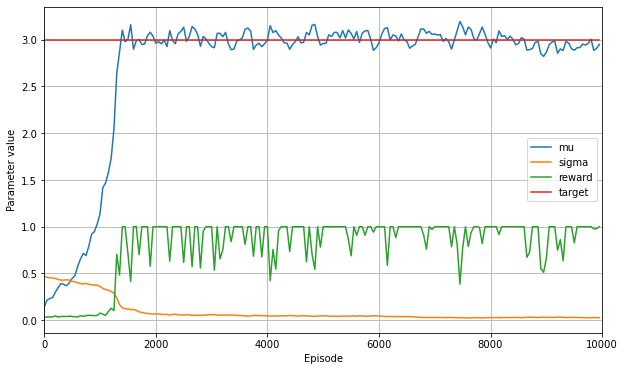

In [5]:
# Initialize fixed state
state = tf.constant([[1.0]])

# Define properties reward function
mu_target = 3.0
target_precision = 0.1
max_reward = 1.0

# Create actor network
actor_network = construct_actor_network()
opt = keras.optimizers.Adam(learning_rate=0.001)

# Initialize arrays for plot
epoch_ar = []
mu_ar = []
sigma_ar=[]
reward_ar=[]
target_ar=[]

for i in range(10000):    
    
    # Obtain mu and sigma from network
    mu, sigma = actor_network(state)
    
    # Draw action from normal distribution
    action = tf.random.normal([1], mean=mu, stddev=sigma)
   
    # Compute reward
    reward = max_reward/ max(target_precision, abs(mu_target-action)) * target_precision

    # Update network weights  
    with tf.GradientTape() as tape:   
        # Compute Gaussian loss
        loss_value = -reward * log_policy(state, action)
        
        # Compute gradients
        grads = tape.gradient(loss_value, actor_network.trainable_variables)
 
        #Apply gradients to update network weights
        opt.apply_gradients(zip(grads, actor_network.trainable_variables))
        
        
    # Update console output and plot
    if np.mod(i, 50) == 0:
        clear_output(wait=True)
        plot() 